In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from model.helper import load_loan_apr_monthly, load_hpi_master, load_fmr_by_region, load_houseprices_by_urban_codes

In [42]:
from model.price_model import PriceModel
from model.rent_model import RentModel

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [43]:
apr = load_loan_apr_monthly().reset_index().rename(columns={'DATE': 'Date' })
hpi_ma = load_hpi_master('New England Division')
house_prices, selected_counties = load_houseprices_by_urban_codes(state="MA")
fmr = load_fmr_by_region(selected_counties)
fmr = fmr[fmr.Date.dt.year<2018]

In [44]:
pm = PriceModel()
pm.fit_all()

In [45]:
pm.prp_features.head()

,Date,apr_savgol,hpi_sa_savgol,apr_savgol_div_1,apr_savgol_div_2
1356,1991-01-31,0.095275,100.954476,-0.000120,0.000061
1357,1991-02-28,0.095156,101.242168,-0.000058,0.000064
1358,1991-03-31,0.095159,101.157576,0.000008,0.000011
1359,1991-04-30,0.095172,100.794138,-0.000037,-0.000101
1360,1991-05-31,0.095085,100.245291,-0.000194,-0.000212


In [46]:
features = apr.merge(hpi_ma[['Date', 'hpi_sa']], on='Date').merge(fmr, on='Date') 
features.tail()

,Date,apr,hpi_sa,fmr
176,2017-08-31,0.03880,238.32,1633.499823
177,2017-09-30,0.03805,239.32,1639.212843
178,2017-10-31,0.03895,241.67,1644.925864
179,2017-11-30,0.03922,241.96,1650.638884
180,2017-12-31,0.03950,243.60,1656.351905


In [47]:
price = pm.predict(features)
price = price.merge(pm.features_and_targets[['Date', 'rooms', 'urban_code', 'target']] , on=['Date', 'rooms', 'urban_code'], how='left')

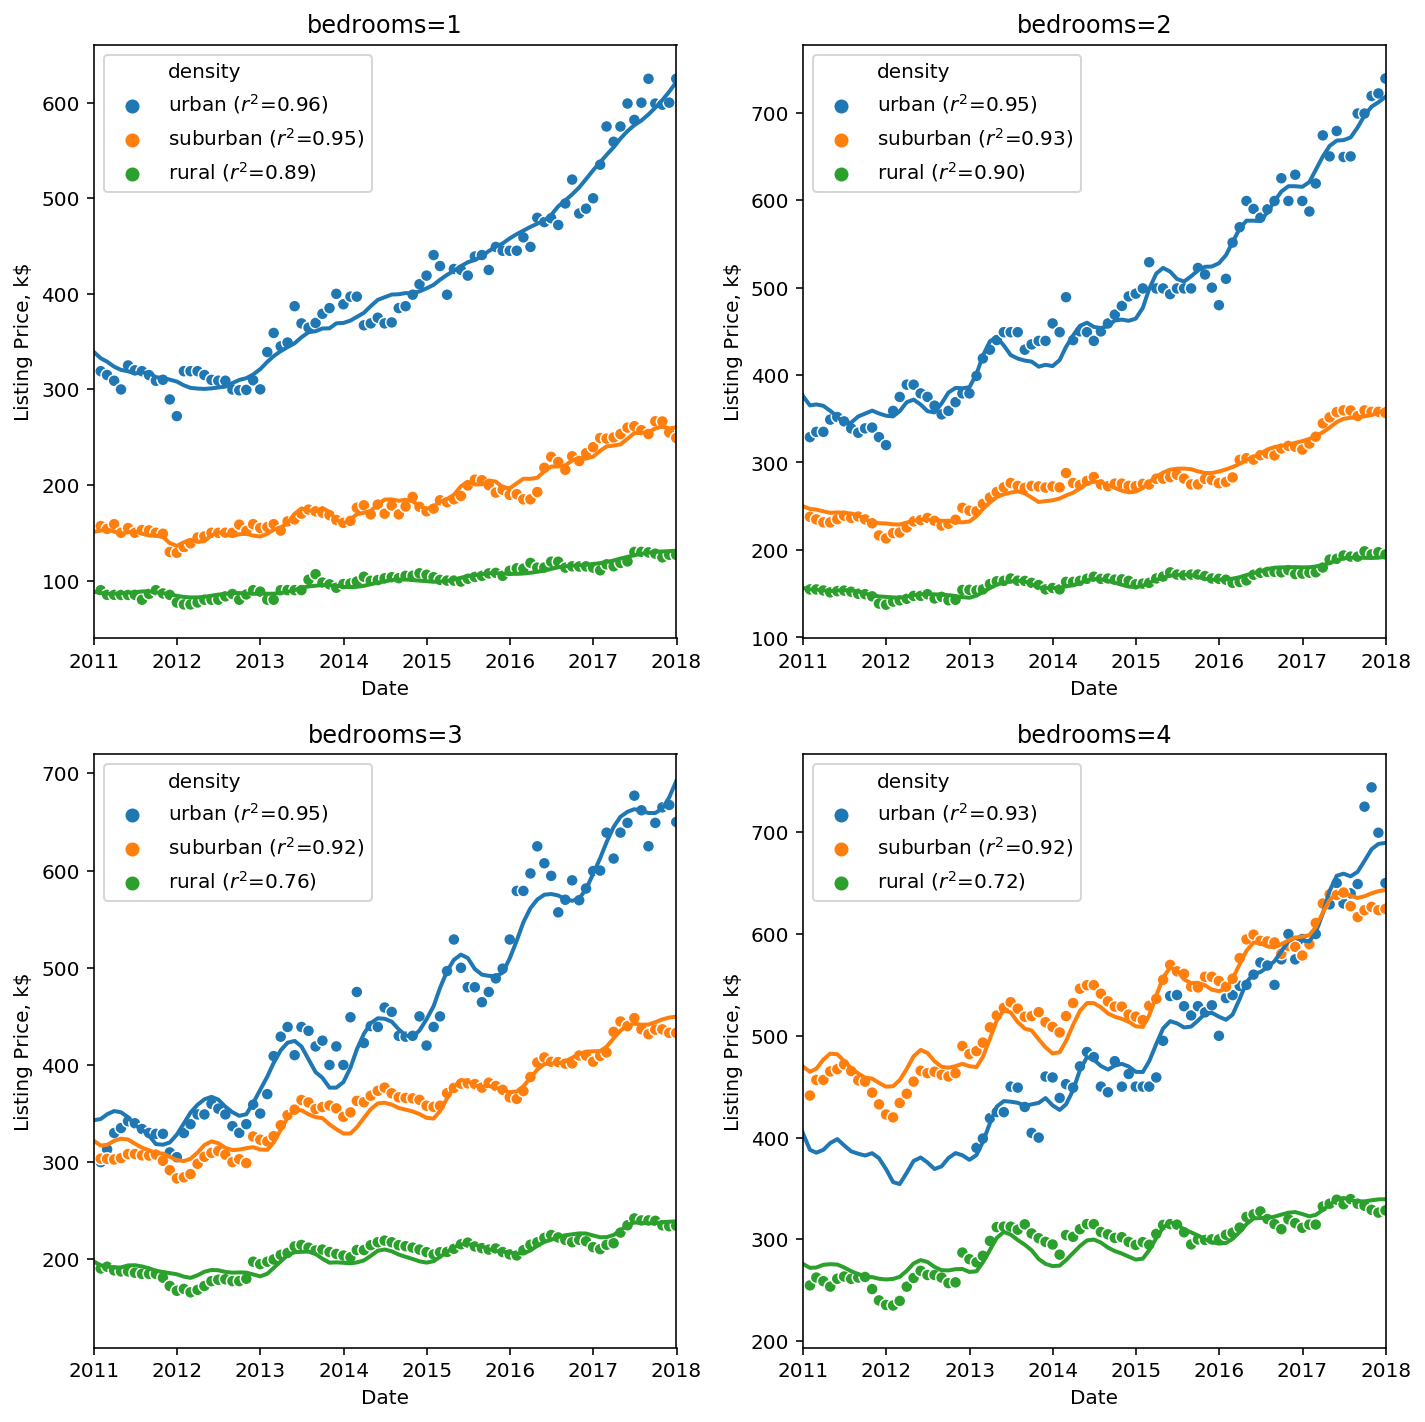

In [48]:
fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=price[price.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    ax = sns.scatterplot(data=price[price.rooms==r], x='Date', y='target', hue='density', lw=2)
    handles, labels = ax.get_legend_handles_labels()
    
    for u in range(1,4):
        r2 = pm.models.loc[(pm.models.rooms==r) & (pm.models.urban_code==u) , 'model'].values[0].best_score_
        labels[u] += f' ($r^2$={r2:.2f})'
    ax.legend(handles, labels)

    plt.xlim(datetime.date(2011, 1,1), datetime.date(2018, 1,1))
    plt.title(f'bedrooms={r}')
    plt.ylabel('Listing Price, k$')
    axs.append(ax)

# axs[-1].set_ylim(1000,4000)
plt.tight_layout()

In [54]:
rm = RentModel()
rm.fit_all()

In [56]:
rent = rm.predict(features)
rent = rent.merge(rm.features_and_targets[['Date', 'rooms', 'urban_code', 'target']] , on=['Date', 'rooms', 'urban_code'], how='left')

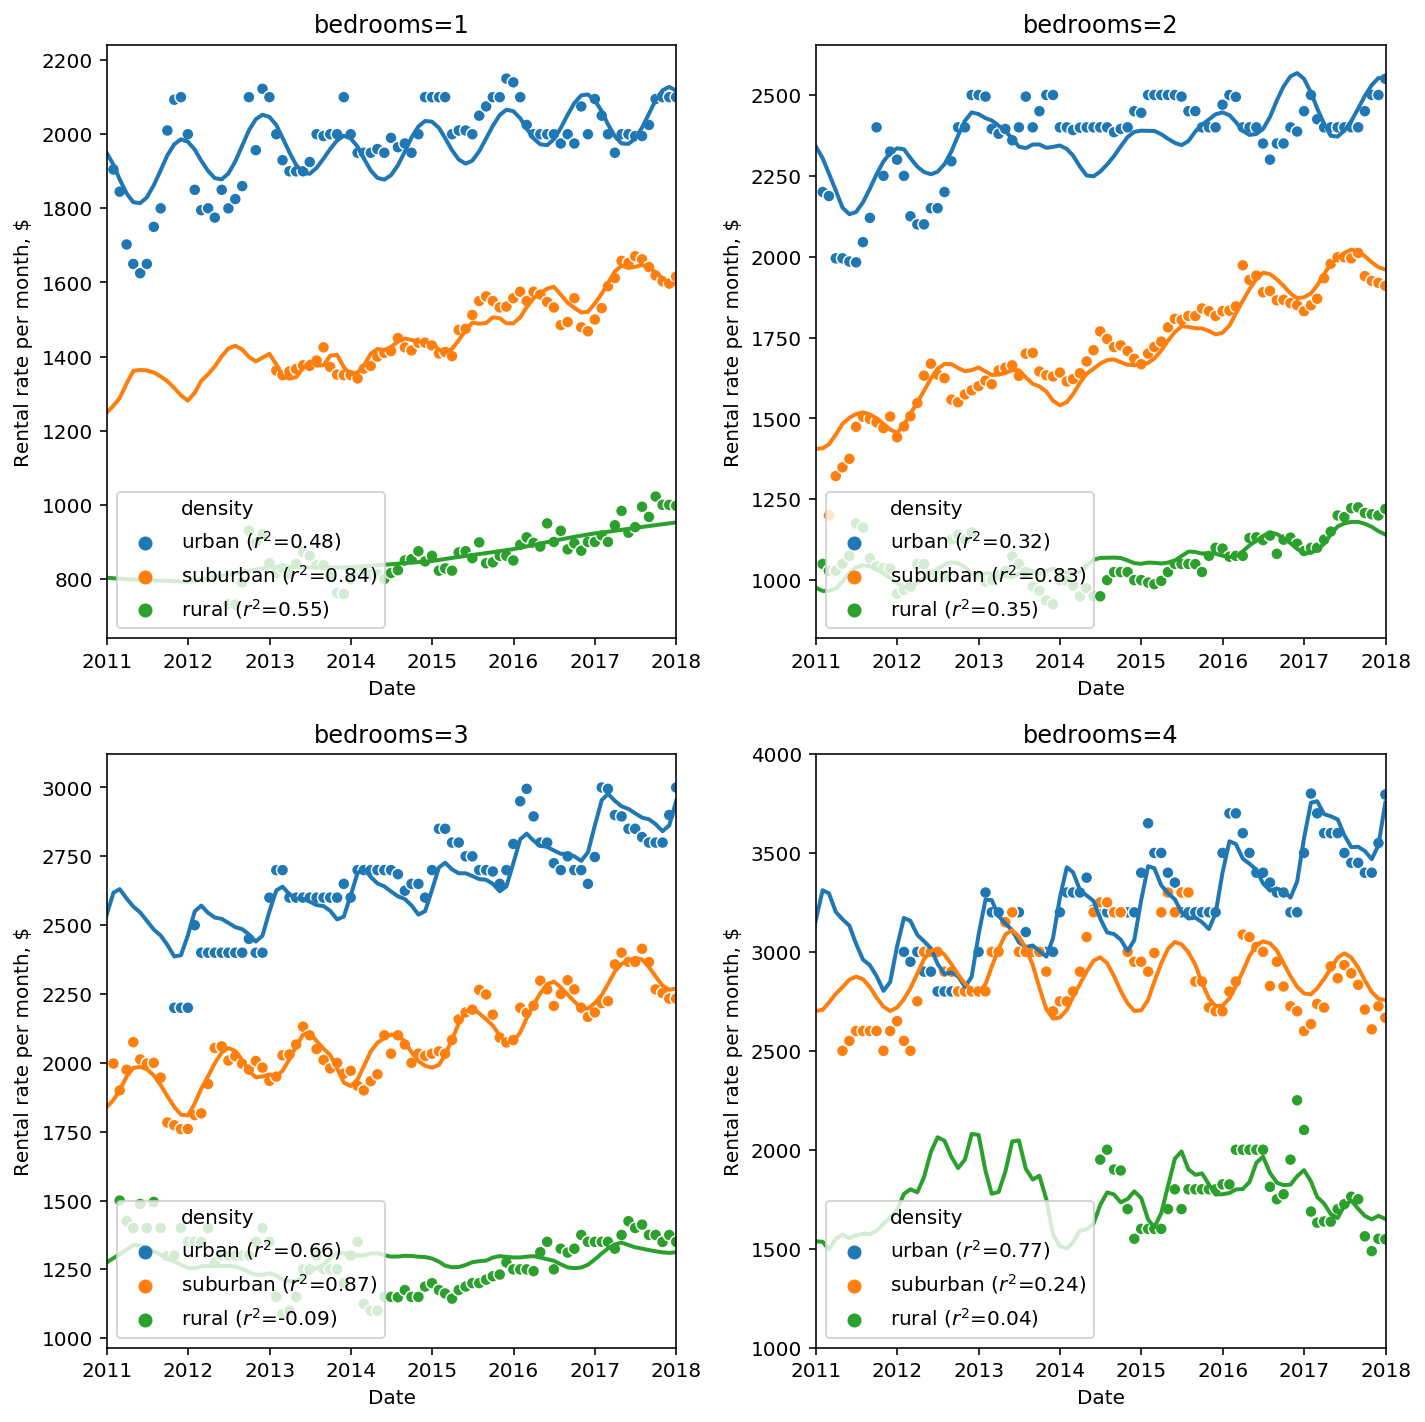

In [58]:
fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=rent[rent.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    ax = sns.scatterplot(data=rent[rent.rooms==r], x='Date', y='target', hue='density', lw=2)
    plt.xlim(datetime.date(2011, 1,1), datetime.date(2018, 1,1))
    plt.title(f'bedrooms={r}')
    
    handles, labels = ax.get_legend_handles_labels()
    
    for u in range(1,4):
        r2 = rm.models.loc[(rm.models.rooms==r) & (rm.models.urban_code==u) , 'model'].values[0].best_score_
        labels[u] += f' ($r^2$={r2:.2f})'
    ax.legend(handles, labels, loc=3)
    
    plt.ylabel('Rental rate per month, $')
    axs.append(ax)

axs[-1].set_ylim(1000,4000)
# for ax in axs:
#     ax.legend(loc=4)

plt.tight_layout()

### So the models work, let's predict the future

In [44]:
years = 6

future = pd.DataFrame()

future['Date'] = pd.Series(pd.date_range('2018-01-01', periods=12*years, freq='M', name='Date'))

### Market collapse

In [46]:
def sigm(a, b, x0, x):
    out = a*(1/(1 + np.exp(-b*(x-x0))))
    return out

In [93]:
lm = LinearRegression()
lm.fit(hpi_ma[hpi_ma.Date>'2016-01-01'][['Date']].astype(int), hpi_ma.loc[hpi_ma.Date>'2016-01-01', 'hpi_sa'])
future['hpi_sa'] = lm.predict(future[['Date']].astype(int))
lm.fit(fmr[fmr.Date>'2012-01-01'][['Date']].astype(int), fmr.loc[fmr.Date>'2012-01-01', 'fmr'])
future['fmr'] = lm.predict(future[['Date']].astype(int))
lm.fit(apr[apr.Date>'2013-01-01'][['Date']].astype(int), apr.loc[apr.Date>'2013-01-01', 'apr'])
future['apr'] = lm.predict(future[['Date']].astype(int))
future['hpi_sa_1'] = future['hpi_sa'] +  sigm(0, 5e-17, future.loc[35:35,'Date'].astype(int).values[0], future['Date'].astype(int))
future['hpi_sa_2'] = future['hpi_sa'] +  sigm(-40, 5e-17, future.loc[35:35,'Date'].astype(int).values[0], future['Date'].astype(int))
future['hpi_sa_3'] = future['hpi_sa'] +  sigm(-80, 5e-17, future.loc[35:35,'Date'].astype(int).values[0], future['Date'].astype(int))

future['fmr_1'] = future['fmr'] +  sigm(0, 5e-17, future.loc[55:55,'Date'].astype(int).values[0], future['Date'].astype(int))

future['fmr_2'] = future['fmr'] +  sigm(-100, 5e-17, future.loc[55:55,'Date'].astype(int).values[0], future['Date'].astype(int))

future['fmr_3'] = future['fmr'] +  sigm(-200, 5e-17, future.loc[55:55,'Date'].astype(int).values[0], future['Date'].astype(int))
    

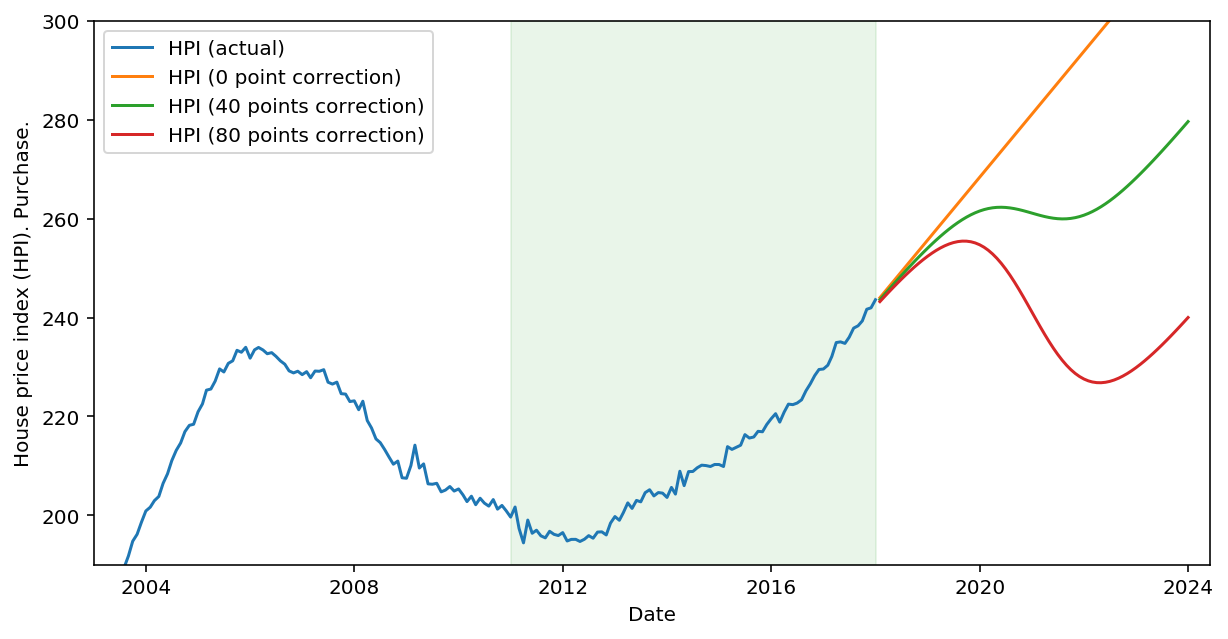

In [75]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data = hpi_ma[:-15:], x='Date', y='hpi_sa', label='HPI (actual)')
# ax = sns.lineplot(data = future, x='Date', y='hpi_sa', label='HPI forecast')
ax = sns.lineplot(data = future, x='Date', y='hpi_sa_1', label='HPI (0 point correction)')
ax = sns.lineplot(data = future, x='Date', y='hpi_sa_2', label='HPI (40 points correction)')
ax = sns.lineplot(data = future, x='Date', y='hpi_sa_3', label='HPI (80 points correction)')
plt.xlim(datetime.date(2003, 1,1), datetime.date(2018+years, 6,1))
plt.ylim(190, 300)

plt.ylabel('House price index (HPI). Purchase.')

plt.axvspan(pd.to_datetime('2011-01-01'), pd.to_datetime('2018-01-01'), alpha=0.1, color='C2')

(731216.0, 739038.0)

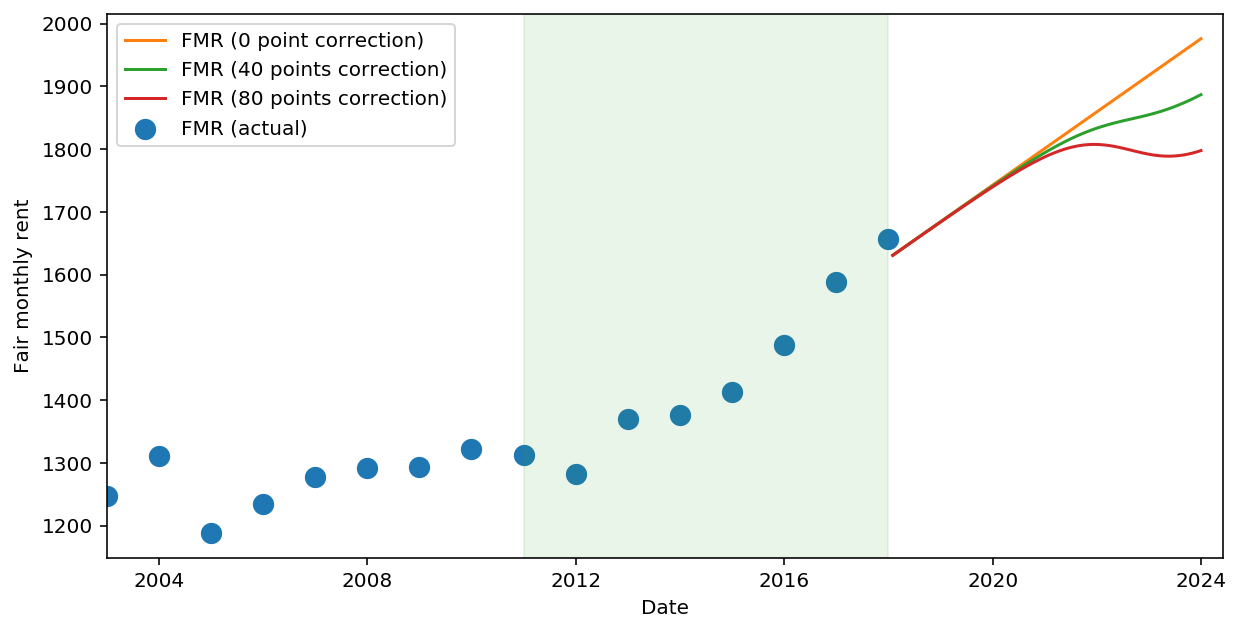

In [99]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=features[::12], x='Date', y='fmr', label='FMR (actual)', s=130)
# sns.lineplot(data=features[::12], x='Date', y='fmr', label='FMR (actual)')
plt.ylabel('Average Fair Monthly Rent, $')


ax = sns.lineplot(data = future, x='Date', y='fmr_1', label='FMR (0 point correction)', color='C1')
ax = sns.lineplot(data = future, x='Date', y='fmr_2', label='FMR (40 points correction)', color='C2')
ax = sns.lineplot(data = future, x='Date', y='fmr_3', label='FMR (80 points correction)', color='C3')


plt.ylabel('Fair monthly rent')

plt.axvspan(pd.to_datetime('2011-01-01'), pd.to_datetime('2018-01-01'), alpha=0.1, color='C2')

plt.xlim(datetime.date(2003, 1,1), datetime.date(2018+years, 6,1))

In [108]:
future.head()

,Date,hpi_sa,fmr,apr,hpi_sa_1,hpi_sa_2,hpi_sa_3,fmr_1,fmr_2,fmr_3
0,2018-01-31,244.008604,1630.734589,0.041638,244.008604,243.610847,243.213090,1630.734589,1630.661998,1630.589407
1,2018-02-28,244.984607,1635.207302,0.041688,244.984607,244.536280,244.087953,1635.207302,1635.125385,1635.043468
2,2018-03-31,246.065183,1640.159234,0.041743,246.065183,245.553431,245.041680,1640.159234,1640.065589,1639.971944
3,2018-04-30,247.110900,1644.951427,0.041796,247.110900,246.529366,245.947832,1644.951427,1644.844838,1644.738249
4,2018-05-31,248.191475,1649.903359,0.041850,248.191475,247.527989,246.864503,1649.903359,1649.781514,1649.659670


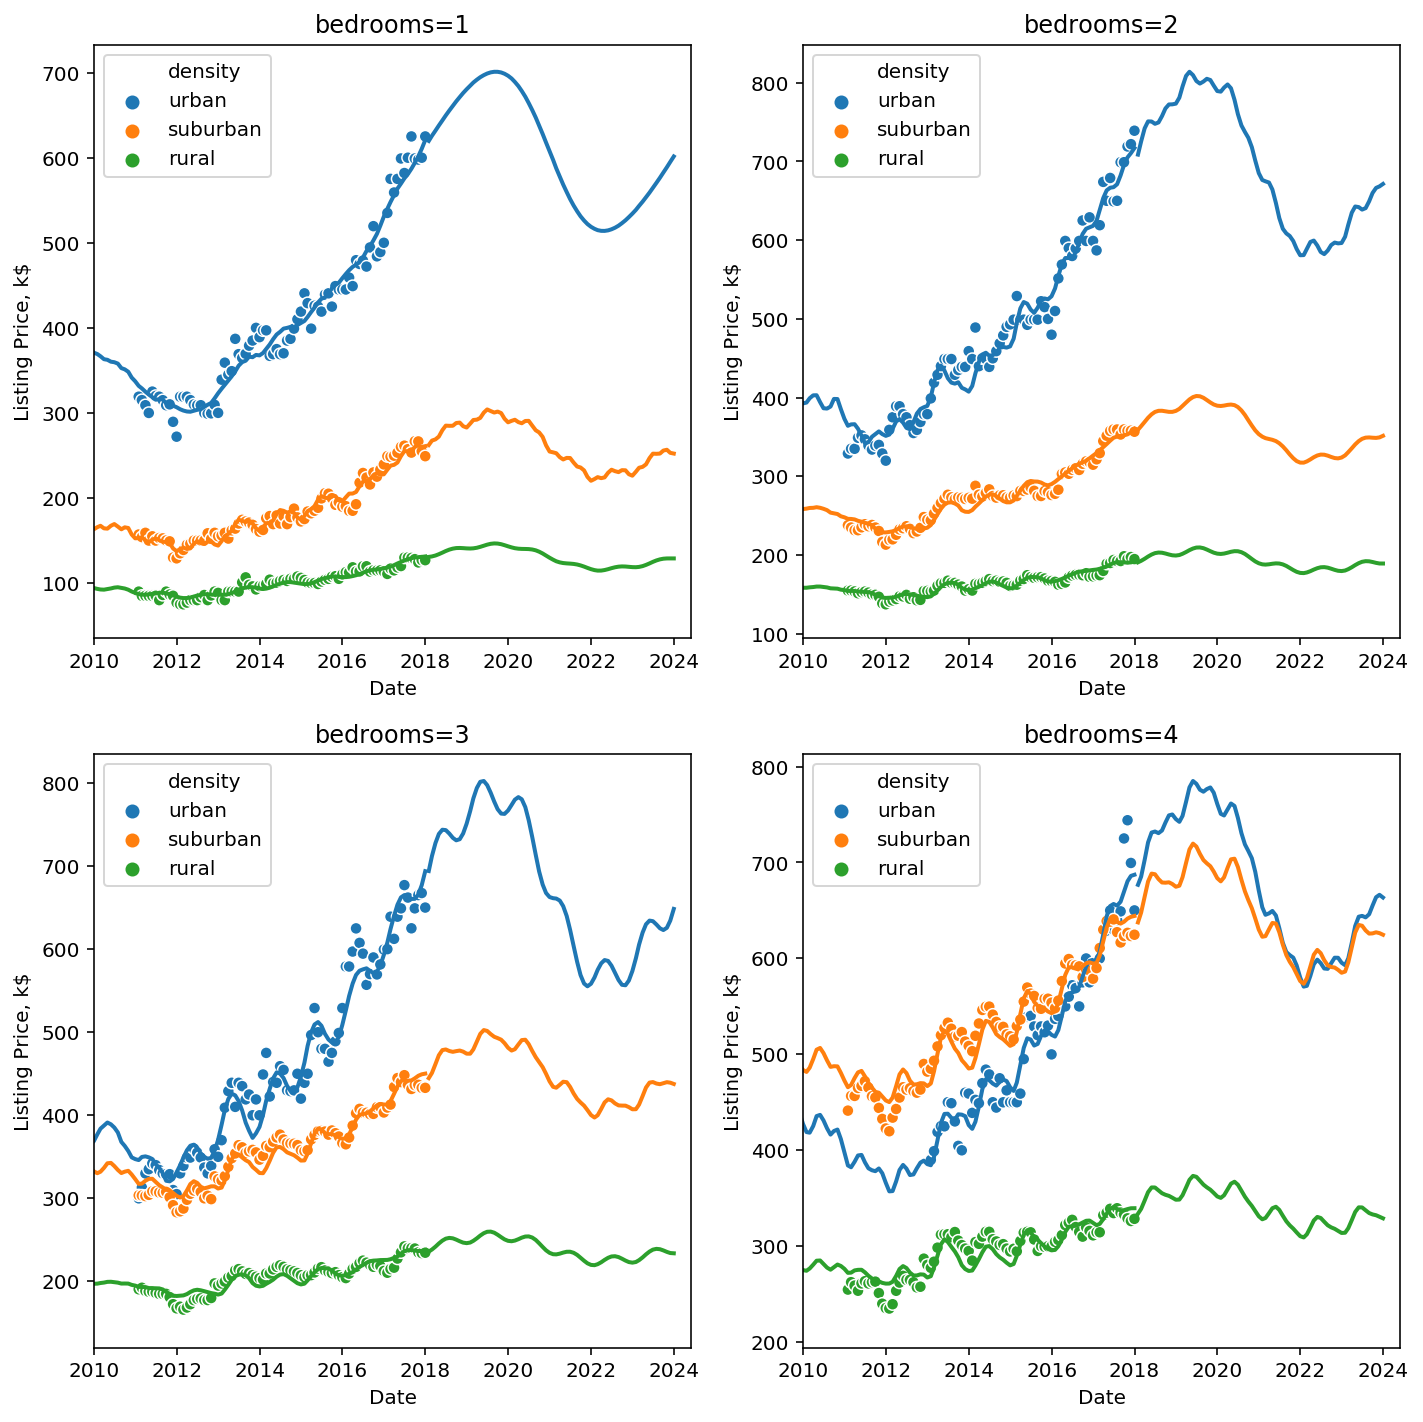

In [117]:
fi = 3


f = future.copy()
f.hpi_sa = f[f'hpi_sa_{fi}']
f.fmr = f[f'fmr_{fi}']

future_rent = rm.predict(f)
future_price = pm.predict(f)

fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=price[price.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    sns.lineplot(data=future_price[future_price.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    ax = sns.scatterplot(data=price[price.rooms==r], x='Date', y='ListingPrice', hue='density', lw=2)
    plt.xlim(datetime.date(2010, 1,1), datetime.date(2024, 6,1))
    plt.ylabel('Listing Price, k$')
    plt.title(f'bedrooms={r}')
    axs.append(ax)

plt.tight_layout()

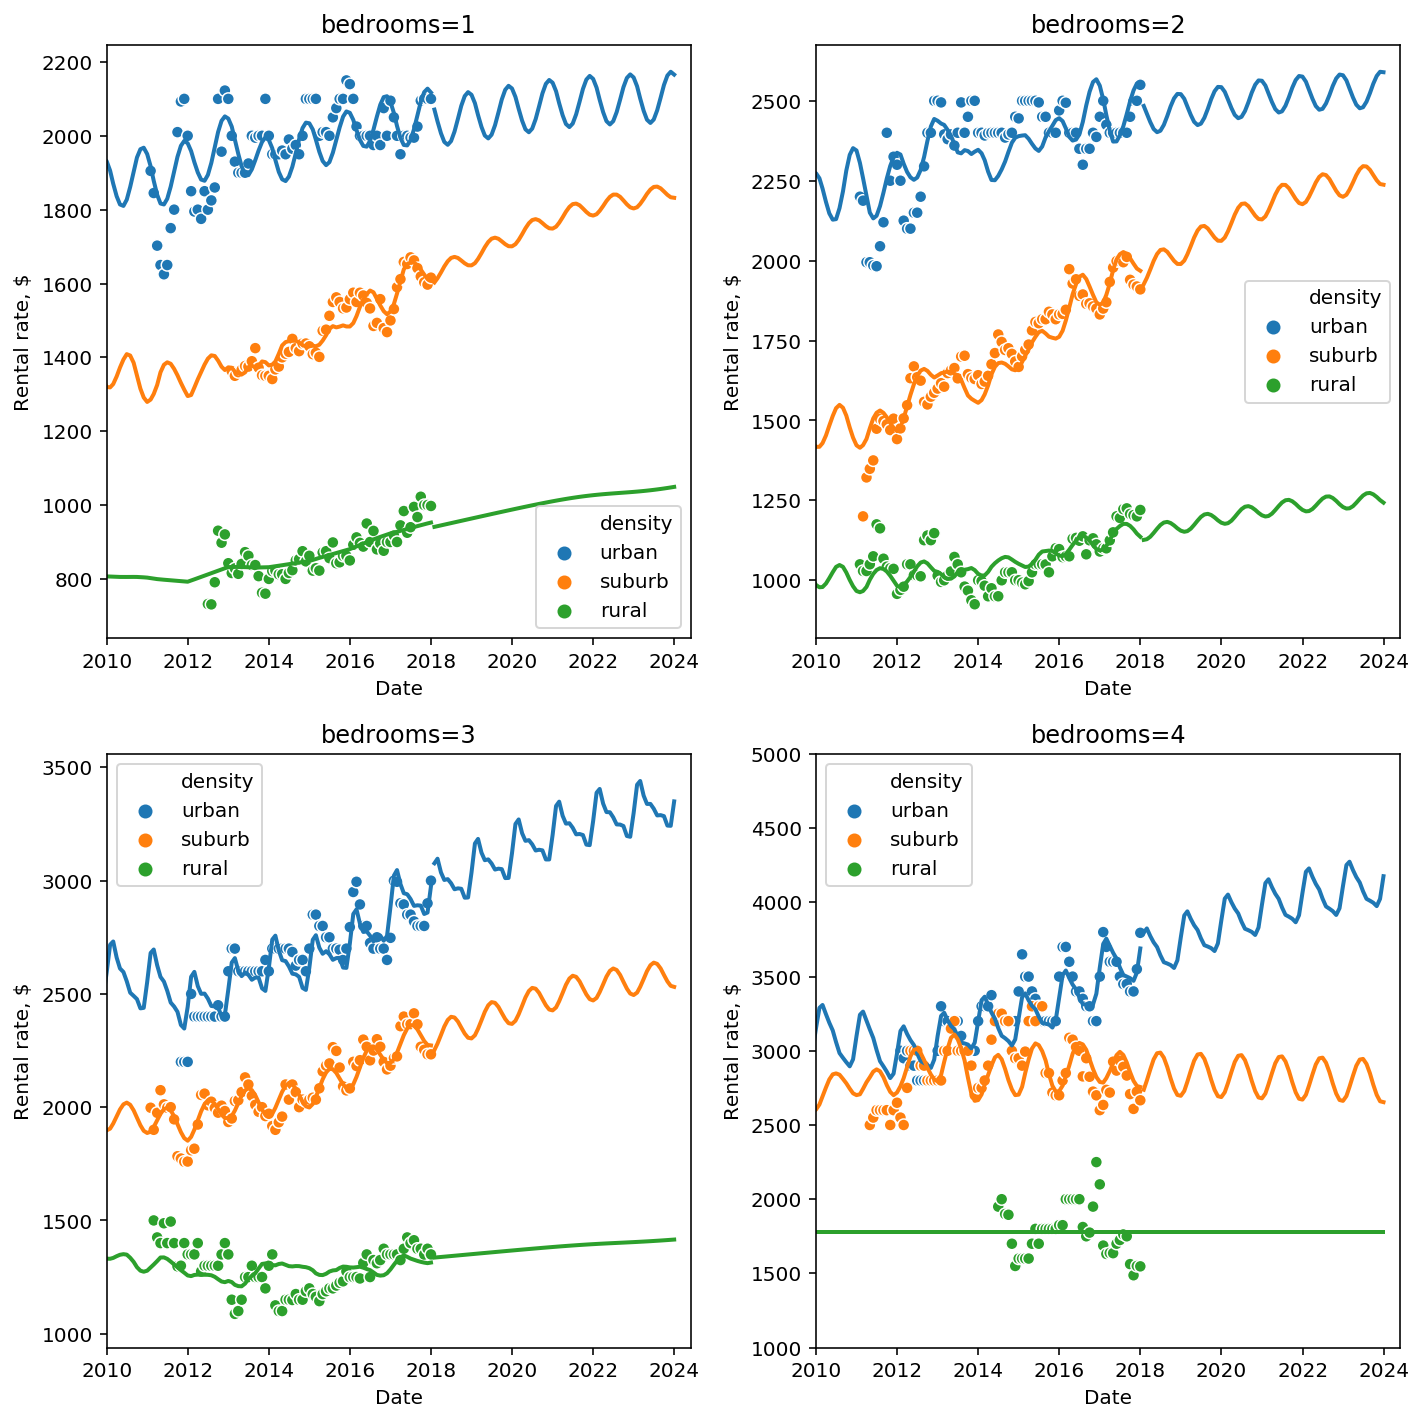

In [126]:
fi = 2


f = future.copy()
f.hpi_sa = f[f'hpi_sa_{fi}']
f.fmr = f[f'fmr_{fi}']

future_rent = rm.predict(f)
future_price = pm.predict(f)

fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=rent[rent.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    sns.lineplot(data=future_rent[future_rent.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    ax = sns.scatterplot(data=rent[rent.rooms==r], x='Date', y='RentalPrice', hue='density', lw=2)
    plt.xlim(datetime.date(2010, 1,1), datetime.date(2024, 6,1))
    plt.title(f'bedrooms={r}')
    plt.ylabel('Rental rate, $')
    axs.append(ax)

# axs[-1].lines.remove(axs[-1].lines[-1])
# axs[-2].lines.remove(axs[-2].lines[-1])
axs[-1].set_ylim(1000,5000)
plt.tight_layout()

In [149]:
def rental_cost(df, t0, row):

    r = row.rooms
    uc = row.urban_code
    t =  row.Date
    
    dfur = df[(df.rooms==r) & (df.urban_code==uc)]
    acc = 0
    year = 12*pd.tseries.offsets.MonthEnd()
    while t0 < t:
        if (t - t0).days > 365:
            acc+=dfur.loc[dfur.Date==t0, 'y_hat'].values[0]*12
        else:
            acc+=dfur.loc[dfur.Date==t0, 'y_hat'].values[0]*(t - t0).days/30
        t0 += year
    return acc

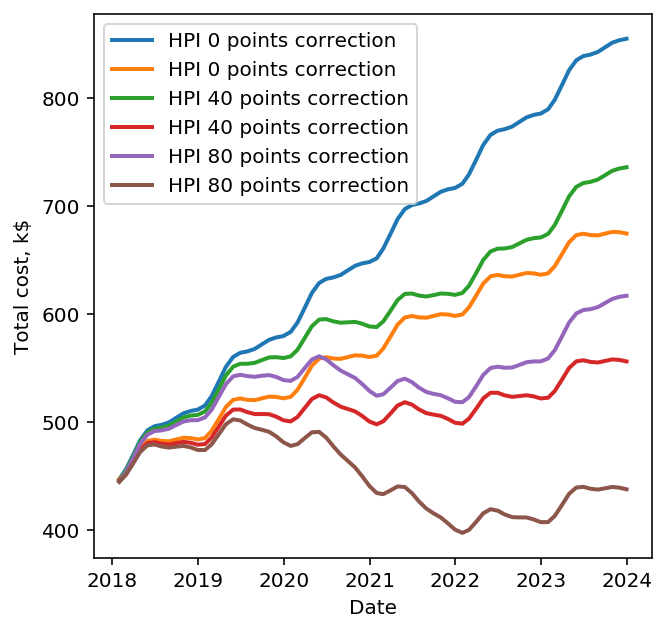

In [212]:
fig = plt.figure(figsize=(5,5))

for fi in range(1, 4):

    f = future.copy()
    f.hpi_sa = f[f'hpi_sa_{fi}']
    f.fmr = f[f'fmr_{fi}']

    future_price = pm.predict(f)
    future_rent = rm.predict(f)
    future_rent['total_rent_cost'] = future_rent.apply(lambda r: rental_cost(future_rent, pd.to_datetime('2018-01-31'), r), axis=1)
    target = future_rent.merge(future_price, on=['Date'], suffixes=['_rent', '_list'])
    target['cost'] = (target.y_hat_list*1000 + target.total_rent_cost)/1000

    st1 = target[(target.urban_code_rent==1) & (target.rooms_rent==2) &(target.urban_code_list==2) & (target.rooms_list==3)]
    sns.lineplot(data=st1, x='Date', y='cost', lw=2, label=f'HPI {40*(fi-1)} points correction')
    
#     sns.lineplot(data=st1, x='Date', y='y_hat_list', lw=2, label=f'HPI {40*(fi-1)} points correction')
    plt.ylabel('Total cost, k$')


In [209]:
target

,Date,y_hat_rent,urban_code_rent,rooms_rent,density_rent,total_rent_cost,y_hat_list,urban_code_list,rooms_list,density_list,cost
0,2018-01-31,2070.894779,1,1,urban,0.000000,619.595785,1,1,urban,619.595785
1,2018-01-31,2070.894779,1,1,urban,0.000000,262.193290,2,1,suburban,262.193290
2,2018-01-31,2070.894779,1,1,urban,0.000000,130.682363,3,1,rural,130.682363
3,2018-01-31,2070.894779,1,1,urban,0.000000,708.659827,1,2,urban,708.659827
4,2018-01-31,2070.894779,1,1,urban,0.000000,359.072079,2,2,suburban,359.072079
5,2018-01-31,2070.894779,1,1,urban,0.000000,190.767145,3,2,rural,190.767145
6,2018-01-31,2070.894779,1,1,urban,0.000000,693.936370,1,3,urban,693.936370
7,2018-01-31,2070.894779,1,1,urban,0.000000,444.595666,2,3,suburban,444.595666
8,2018-01-31,2070.894779,1,1,urban,0.000000,235.794632,3,3,rural,235.794632
9,2018-01-31,2070.894779,1,1,urban,0.000000,676.689834,1,4,urban,676.689834


In [177]:
def calc_all_prices(hpi_correction):
    lm = LinearRegression()
    lm.fit(hpi_ma[hpi_ma.Date>'2016-01-01'][['Date']].astype(int), hpi_ma.loc[hpi_ma.Date>'2016-01-01', 'hpi_sa'])
    future['hpi_sa'] = lm.predict(future[['Date']].astype(int))
    lm.fit(fmr[fmr.Date>'2012-01-01'][['Date']].astype(int), fmr.loc[fmr.Date>'2012-01-01', 'fmr'])
    future['fmr'] = lm.predict(future[['Date']].astype(int))
    lm.fit(apr[apr.Date>'2013-01-01'][['Date']].astype(int), apr.loc[apr.Date>'2013-01-01', 'apr'])
    future['apr'] = lm.predict(future[['Date']].astype(int))
    future['hpi_sa'] = future['hpi_sa'] +  sigm(-hpi_correction, 5e-17, future.loc[35:35,'Date'].astype(int).values[0], future['Date'].astype(int))

    
    future['fmr'] = future['fmr'] +  sigm(-hpi_correction*100/40, 5e-17, future.loc[55:55,'Date'].astype(int).values[0], future['Date'].astype(int))

   
    future_price = pm.predict(future)
    future_rent = rm.predict(future)
    future_rent['total_rent_cost'] = future_rent.apply(lambda r: rental_cost(future_rent, pd.to_datetime('2018-01-31'), r), axis=1)
    target = future_rent.merge(future_price, on=['Date'], suffixes=['_rent', '_list'])
    target['cost'] = (target.y_hat_list*1000 + target.total_rent_cost)/1000
    
    target = target[target.Date > '2019-06-01']
    
    optimal_buy = target.groupby([
    'urban_code_list', 'rooms_list', 
    'urban_code_rent', 'rooms_rent']).apply(
        lambda df: df.loc[df.cost.idxmin(), ['Date', 'cost', 'density_rent']]
    ).reset_index()

#     optimal_buy = optimal_buy[(optimal_buy.rooms_list>=optimal_buy.rooms_rent) & (optimal_buy.urban_code_list<=optimal_buy.urban_code_rent)]
    return optimal_buy

In [174]:
hpi_correction = 90

In [186]:
corr = np.linspace(0, 100, num = 40)

all_strategies = []

for c in corr:
    df = calc_all_prices(c)
    df['corr'] = c
    all_strategies.append(df)

all_strategies = pd.concat(all_strategies, axis=0)


In [187]:
all_strategies.query('urban_code_rent==1 & rooms_rent==2 & rooms_list==3 & urban_code_list==2')

,urban_code_list,rooms_list,urban_code_rent,rooms_rent,Date,cost,density_rent,corr
73,2,3,1,2,2019-06-30,564.146629,urban,0.000000
73,2,3,1,2,2019-06-30,563.493775,urban,2.564103
73,2,3,1,2,2019-06-30,562.840922,urban,5.128205
73,2,3,1,2,2019-06-30,562.188069,urban,7.692308
73,2,3,1,2,2019-06-30,561.535215,urban,10.256410
73,2,3,1,2,2019-06-30,560.882362,urban,12.820513
73,2,3,1,2,2019-06-30,560.229508,urban,15.384615
73,2,3,1,2,2019-06-30,559.576655,urban,17.948718
73,2,3,1,2,2019-06-30,558.923802,urban,20.512821
73,2,3,1,2,2019-06-30,558.270948,urban,23.076923


Text(0, 0.5, 'Date we must buy')

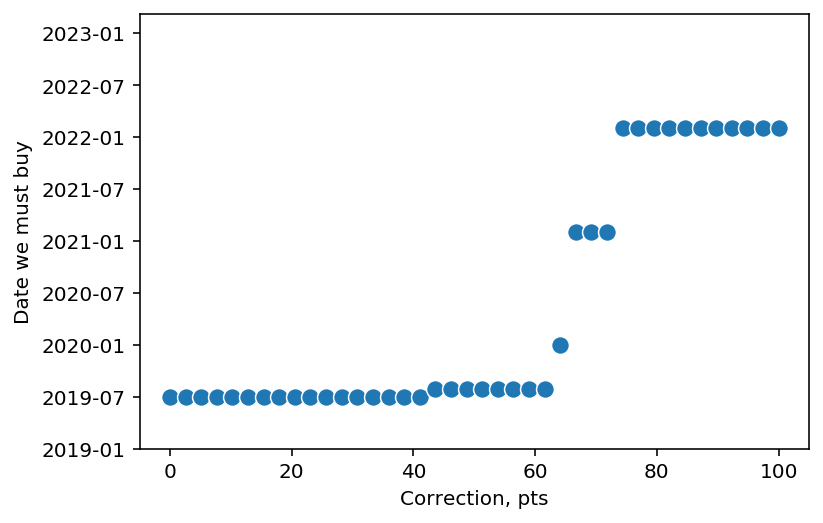

In [194]:
sns.scatterplot(data=all_strategies.query('urban_code_rent==1 & rooms_rent==2 & rooms_list==3 & urban_code_list==2'), x='corr', y='Date', s=80)
plt.ylim(bottom=pd.to_datetime('2019-01-01'))
plt.xlabel('Correction, pts')
plt.ylabel('Date we must buy')


Text(0, 0.5, 'Cost if we buy at optimum, k$')

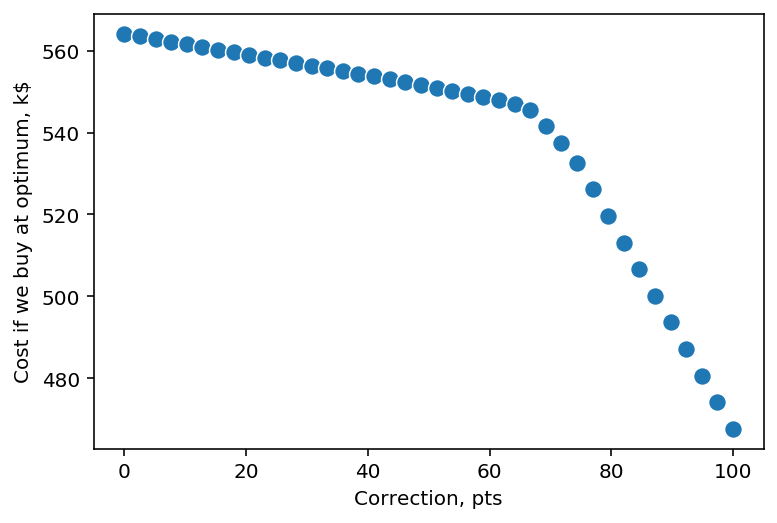

In [199]:
sns.scatterplot(data=all_strategies.query('urban_code_rent==1 & rooms_rent==2 & rooms_list==3 & urban_code_list==2'), x='corr', y='cost', s=80)
# plt.ylim(bottom=pd.to_datetime('2019-01-01'))
plt.xlabel('Correction, pts')
plt.ylabel('Cost if we buy at optimum, k$')

Text(0, 0.5, 'Date we must buy')

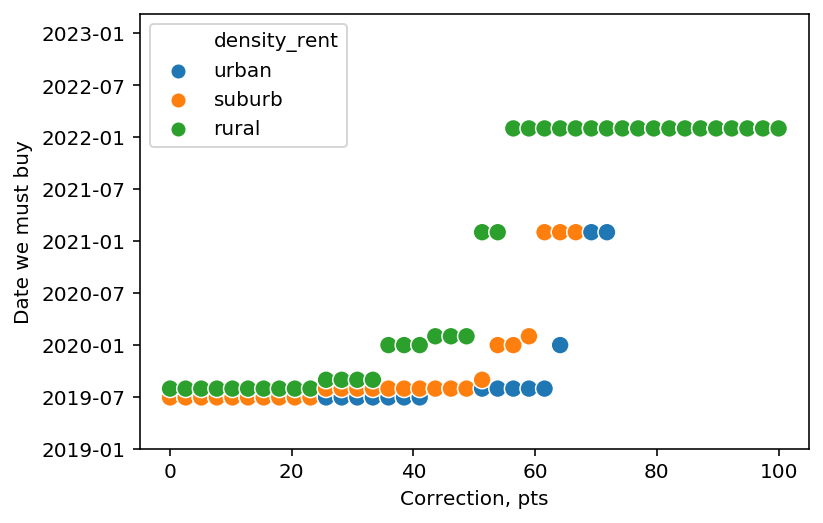

In [205]:
sns.scatterplot(data=all_strategies.query('rooms_rent==2 & rooms_list==3 & urban_code_list==2'), x='corr', y='Date', hue='density_rent', s=80)
plt.ylim(bottom=pd.to_datetime('2019-01-01'))
plt.xlabel('Correction, pts')
plt.ylabel('Date we must buy')


Text(0, 0.5, 'Cost if we buy at optimum, k$')

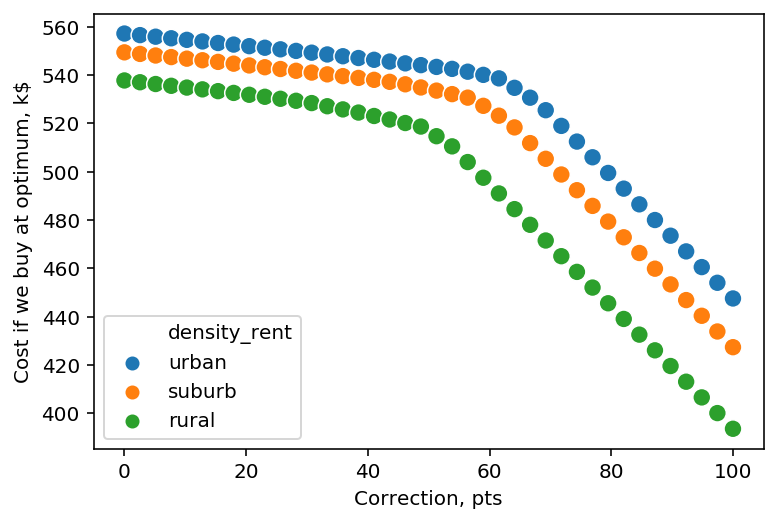

In [206]:
sns.scatterplot(data=all_strategies.query('rooms_rent==1 & rooms_list==3 & urban_code_list==2'), hue='density_rent', x='corr', y='cost', s=80)
# plt.ylim(bottom=pd.to_datetime('2019-01-01'))
plt.xlabel('Correction, pts')
plt.ylabel('Cost if we buy at optimum, k$')

(175, 280)

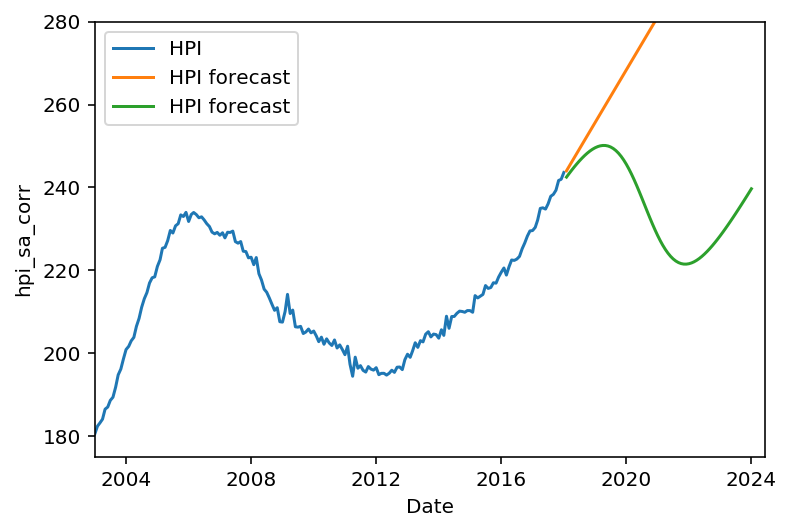

In [19]:
ax = sns.lineplot(data = hpi_ma[:-15:], x='Date', y='hpi_sa', label='HPI')
ax = sns.lineplot(data = future, x='Date', y='hpi_sa', label='HPI forecast')
ax = sns.lineplot(data = future, x='Date', y='hpi_sa_corr', label='HPI forecast')
plt.xlim(datetime.date(2003, 1,1), datetime.date(2018+years, 6,1))
plt.ylim(175, 280)


In [20]:
future['hpi_sa'] =  future['hpi_sa_corr']

(731947.0, 739038.0)

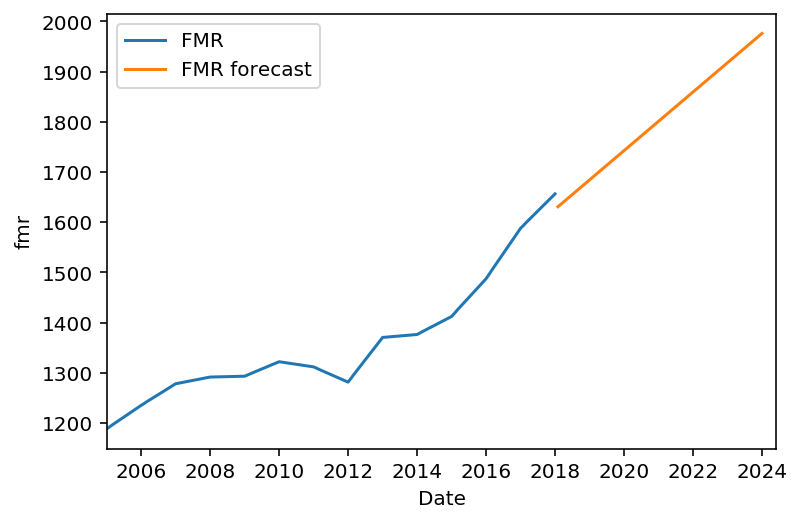

In [21]:
ax = sns.lineplot(data = fmr, x='Date', y='fmr', label='FMR')
ax = sns.lineplot(data = future, x='Date', y='fmr', label='FMR forecast')
plt.xlim(datetime.date(2005, 1,1), datetime.date(2024, 6,1))
# plt.ylim(175, 285)


In [22]:
future['apr_corr'] = future['apr'] +  sigm(-0.015, 5e-17, future.loc[30:30,'Date'].astype(int).values[0], future['Date'].astype(int))

(0.02, 0.1)

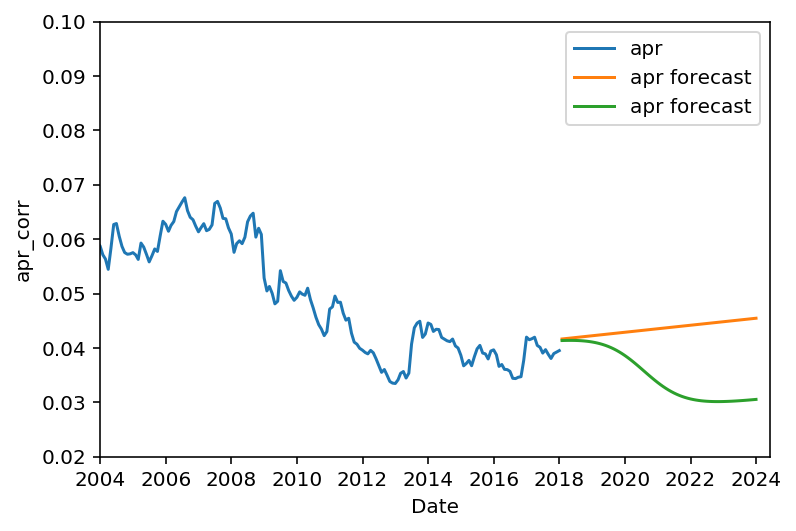

In [23]:
ax = sns.lineplot(data = apr[:-(12+5)], x='Date', y='apr', label='apr')
ax = sns.lineplot(data = future, x='Date', y='apr', label='apr forecast')
ax = sns.lineplot(data = future, x='Date', y='apr_corr', label='apr forecast')
plt.xlim(datetime.date(2004, 1,1), datetime.date(2024, 6,1))
plt.ylim(0.02, 0.1)


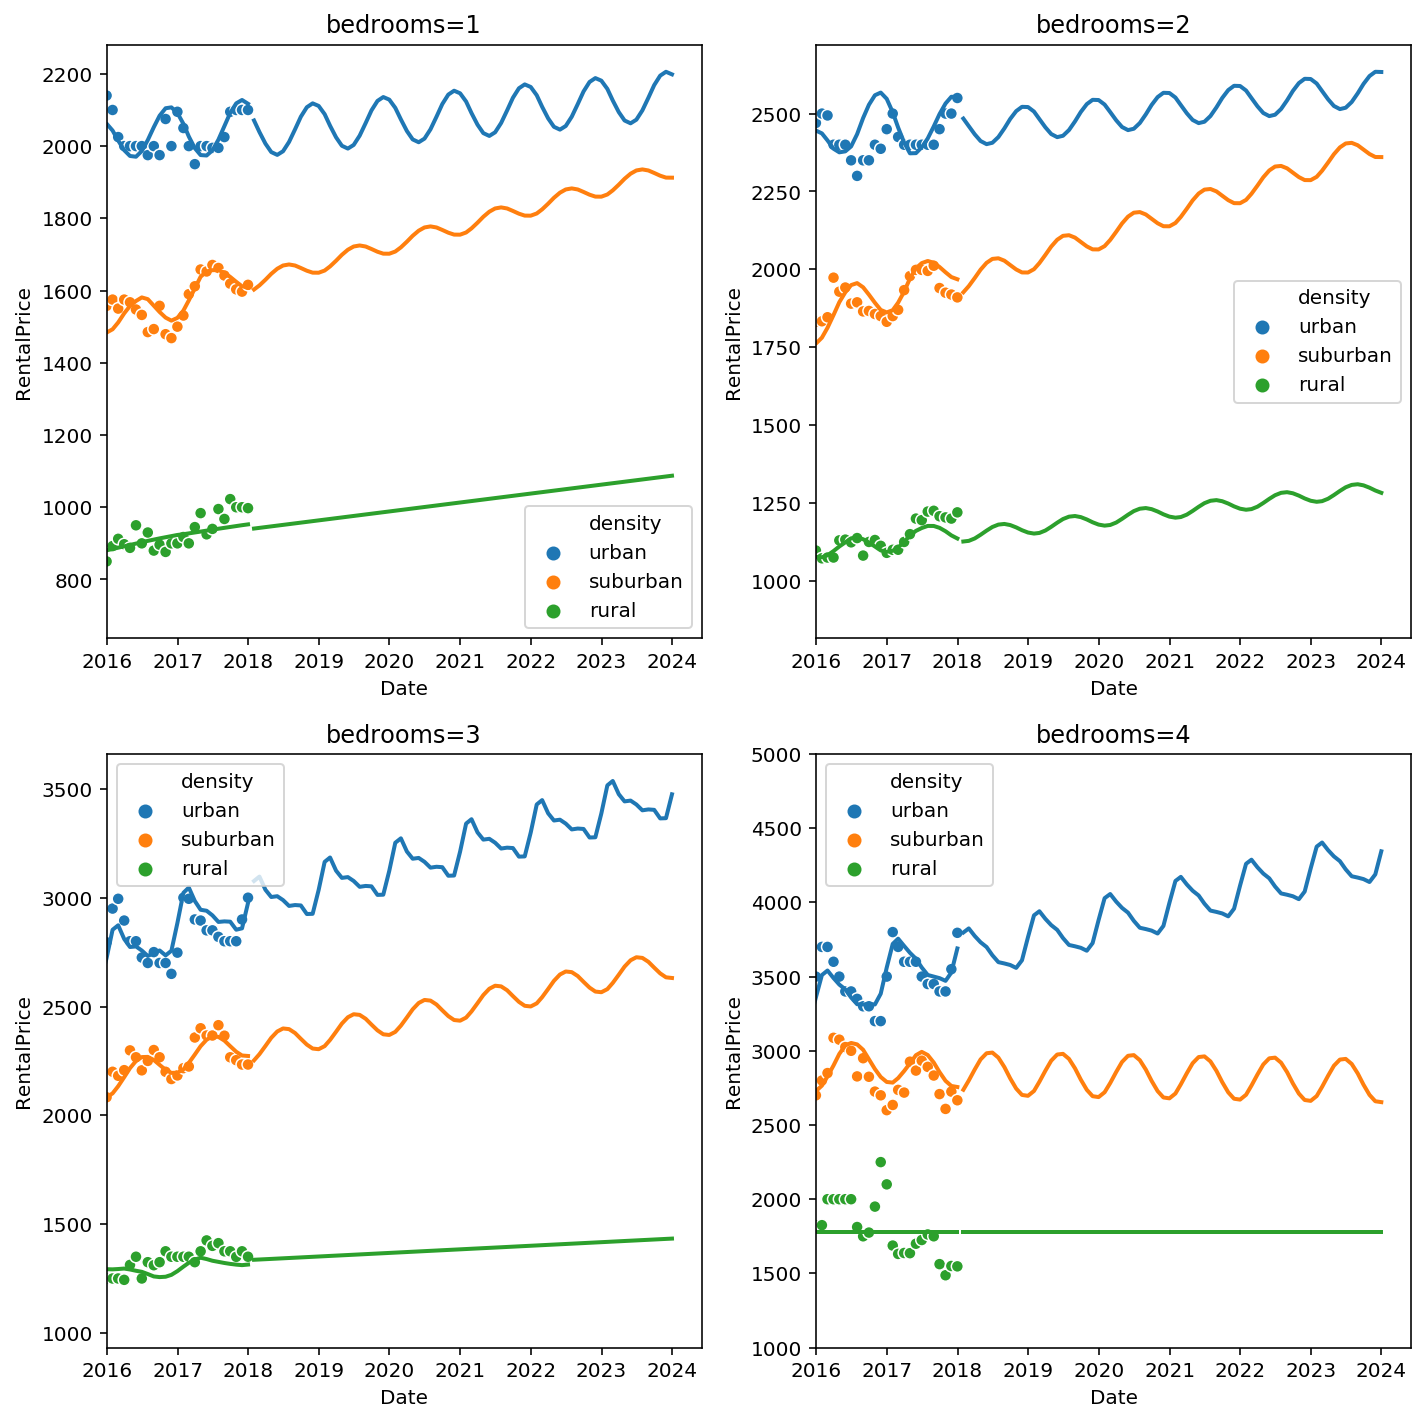

In [142]:
fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=rent[rent.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    sns.lineplot(data=future_rent[future_rent.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    ax = sns.scatterplot(data=rent[rent.rooms==r], x='Date', y='RentalPrice', hue='density', lw=2)
    plt.xlim(datetime.date(2016, 1,1), datetime.date(2024, 6,1))
    plt.title(f'bedrooms={r}')
    axs.append(ax)

# axs[-1].lines.remove(axs[-1].lines[-1])
# axs[-2].lines.remove(axs[-2].lines[-1])
axs[-1].set_ylim(1000,5000)
plt.tight_layout()

In [165]:

target.head()

,Date,y_hat_rent,urban_code_rent,rooms_rent,density_rent,total_rent_cost,y_hat_list,urban_code_list,rooms_list,density_list,cost
0,2018-01-31,2070.948374,1,1,urban,0.0,614.801021,1,1,urban,614.801021
1,2018-01-31,2070.948374,1,1,urban,0.0,260.337648,2,1,suburban,260.337648
2,2018-01-31,2070.948374,1,1,urban,0.0,129.955587,3,1,rural,129.955587
3,2018-01-31,2070.948374,1,1,urban,0.0,703.147834,1,2,urban,703.147834
4,2018-01-31,2070.948374,1,1,urban,0.0,357.113449,2,2,suburban,357.113449


In [166]:
target.loc[target.cost.idxmin(), :]

Date               2018-01-31 00:00:00
y_hat_rent                     2070.95
urban_code_rent                      1
rooms_rent                           1
density_rent                     urban
total_rent_cost                      0
y_hat_list                     129.956
urban_code_list                      3
rooms_list                           1
density_list                     rural
cost                           129.956
Name: 2, dtype: object

,urban_code_list,rooms_list,urban_code_rent,rooms_rent,Date,cost
0,1,1,1,1,2021-08-31,571.231441
1,1,1,1,2,2021-07-31,589.063639
2,1,1,1,3,2018-01-31,614.801021
3,1,1,1,4,2018-01-31,614.801021
4,1,1,2,1,2021-08-31,553.081348


,urban_code_list,rooms_list,urban_code_rent,rooms_rent,Date,cost
0,1,1,1,1,2021-08-31,571.231441
4,1,1,2,1,2021-08-31,553.081348
8,1,1,3,1,2021-09-30,522.431787
12,1,2,1,1,2021-07-31,633.187618
13,1,2,1,2,2021-07-31,650.820603
16,1,2,2,1,2021-12-31,614.709980
17,1,2,2,2,2021-07-31,630.175082
20,1,2,3,1,2021-12-31,581.579001
21,1,2,3,2,2021-12-31,590.372263
24,1,3,1,1,2021-10-31,598.629390


NameError: name 'target' is not defined

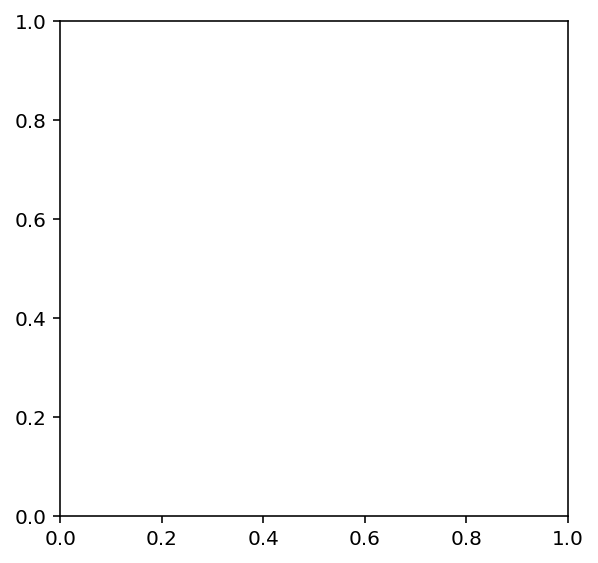

In [127]:
fig = plt.figure(figsize=(10,10))

axs = [] 

for r in range(1,5):
    plt.subplot(220+r)
    sns.lineplot(data=target[target.rooms==r], x='Date', y='cost', hue='density_list',  dashes=[(1,3), (2,2)])
    sns.scatterplot(data=future_price[future_price.rooms==r], x='Date', y='y_hat', hue='density', legend=None, lw=2)
    plt.xlim(datetime.date(2018, 1,1), datetime.date(2024, 1,1))
    plt.title(f'bedrooms={r}')
    axs.append(ax)

plt.tight_layout()